In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [ ]:
# Import data from train set

X_train = pd.read_csv("train.csv", usecols=['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']).values
y_train = pd.read_csv("train.csv", usecols=['is_anomaly']).values.flatten().astype(int)

In [ ]:
# Import data from test set

X_test = pd.read_csv("test.csv", usecols=['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']).values

Creating a class to represent a single node in a decision tree

In [ ]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left_side=None, right_side=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left_side = left_side
        self.right_side = right_side
        self.value = value

Creating a class for the decision tree

In [ ]:
class DecisionTreeClassifier:

    def __init__(self, depth_limit=None):

        self.depth_limit = depth_limit
        self.root = None

    def train(self, features, labels):

        self.root = self._create_tree(features, labels)

    def _create_tree(self, features, labels, current_depth=0):

        num_samples_per_feature = features.shape[1]
        unique_labels = np.unique(labels)

        if current_depth >= self.depth_limit or len(unique_labels) == 1:
            return Node(value=self._most_common_label(labels))

        feature_idx, best_threshold = self._best_split(features, labels, num_samples_per_feature)
        if feature_idx is None:
            return Node(leaf_value=self._most_common_label(labels))

        left_idx, right_idx = self._split(features[:, feature_idx], best_threshold)
        left = self._create_tree(features[left_idx], labels[left_idx], current_depth + 1)
        right = self._create_tree(features[right_idx], labels[right_idx], current_depth + 1)
        return Node(feature_idx, best_threshold, left, right)

    def _best_split(self, features, labels, num_features):

        best_feature, best_threshold = None, None
        best_gini = 1.0

        for feature_index in range(num_features):
            possible_thresholds = np.unique(features[:, feature_index])
            for threshold in possible_thresholds:
                gini_score = self._calculate_gini(features[:, feature_index], labels, threshold)
                if gini_score < best_gini:
                    best_gini = gini_score
                    best_feature = feature_index
                    best_threshold = threshold
        return best_feature, best_threshold

    def _calculate_gini(self, X_feature, labels, threshold):
        left_idxs, right_idxs = self._split(X_feature, threshold)
        n = len(labels)
        n_left, n_right = len(left_idxs), len(right_idxs)
        if n_left == 0 or n_right == 0:
            return 1.0

        gini_left = self._gini_score(labels[left_idxs])
        gini_right = self._gini_score(labels[right_idxs])
        weighted_gini = (n_left / n) * gini_left + (n_right / n) * gini_right
        return weighted_gini

    def _split(self, X_feature, threshold):
        left_idxs = np.where(X_feature <= threshold)[0]
        right_idxs = np.where(X_feature > threshold)[0]
        return left_idxs, right_idxs

    def _gini_score(self, labels):
        label_counts = np.bincount(labels)
        probabilities = label_counts / len(labels)
        gini = 1 - np.sum(probabilities**2)
        return gini

    def _most_common_label(self, labels):
        return np.argmax(np.bincount(labels))

    def predict(self, features):
        predictions = [self._traverse_tree(feature, self.root) for feature in features]
        return np.array(predictions)

    def _traverse_tree(self, feature, node):
        if node.value is not None:
            return node.value
        if feature[node.feature_index] <= node.threshold:
            return self._traverse_tree(feature, node.left_side)
        return self._traverse_tree(feature, node.right_side)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

classifier = DecisionTreeClassifier(depth_limit=10)
classifier.train(X_train_scaled, y_train)

predictions = classifier.predict(X_test_scaled)

submission = pd.read_csv("submission.csv")
submission['is_anomaly'] = predictions
submission.to_csv('submission.csv', index=False)


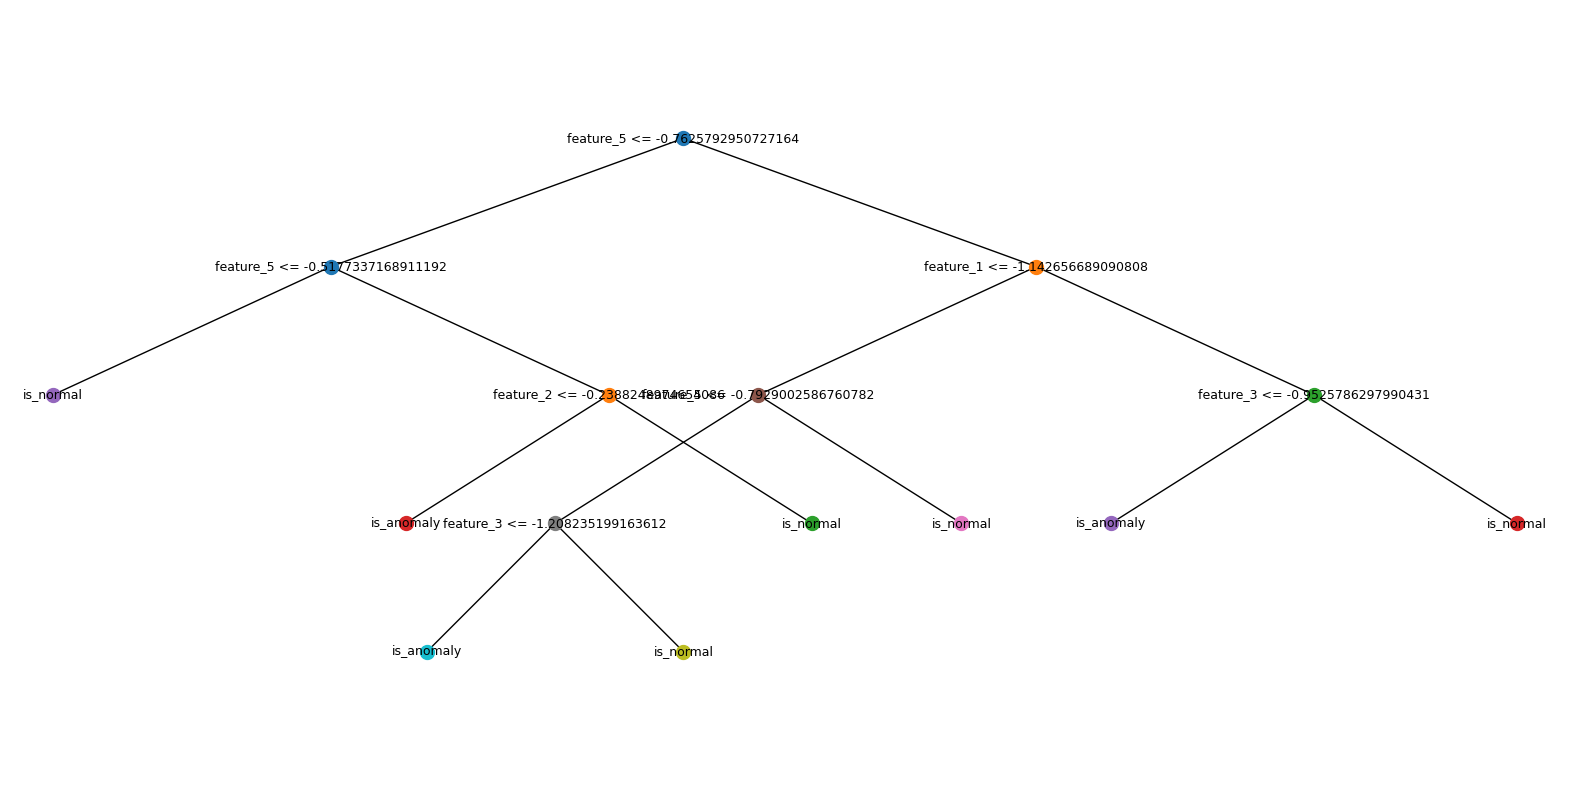

[ 0.35997989 -0.11887798 -0.17089367  0.44891472 -0.30392299 -0.72631168]
[-0.79969955 -0.55659434 -0.17693894 -0.65139792  0.55973082 -0.7786219 ]
[-0.21671999  0.19129418 -0.00198581 -0.21256098  0.18197184 -0.68152265]


In [ ]:
import matplotlib.pyplot as plt
from collections import namedtuple

# A simple structure to hold information about each node for plotting
NodeInfo = namedtuple("NodeInfo", "node depth parent_pos")

def plot_custom_tree(tree, feature_names=None, class_names=None, max_depth=None):
    if not tree.root:
        raise ValueError("Tree is empty")
    if feature_names is None or class_names is None:
        raise ValueError("feature_names and class_names must be provided")

    # Initialize variables for node positions and lines between nodes
    node_positions = {}
    lines = {}
    level_offsets = {}

    def traverse(node, depth, parent_pos, direction):
        if node is None or (max_depth is not None and depth > max_depth):
            return

        nonlocal node_positions, lines, level_offsets

        # Compute the vertical position of the node
        y = depth
        if parent_pos:
            x = parent_pos[0] + (10 - depth*1.75 if direction == "left" else -10 + depth*1.75)
        else:
            x = 0

        node_positions[node] = (x, y)

        # Draw a line from the parent node to the current node
        if parent_pos:
            if depth not in lines:
                lines[depth] = []
            lines[depth].append((parent_pos, (x, y)))

        # Traverse to the next level
        if node.left_side:
            traverse(node.left_side, depth + 1, (x, y), "left")
        if node.right_side:
            traverse(node.right_side, depth + 1, (x, y), "right")

    # Start the tree traversal
    traverse(tree.root, 0, None, None)

    # Create a plot
    fig, ax = plt.subplots(figsize=(20, 10))

    # Draw lines
    for depth, line_segments in lines.items():
        for (x0, y0), (x1, y1) in line_segments:
            ax.plot([x0, x1], [y0, y1], 'k-', lw=1)

    # Draw nodes
    for node, (x, y) in node_positions.items():
        ax.plot(x, y, 'o', markersize=10)

        # Node annotation
        if node.value is not None:
            text = class_names[node.value] if node.value < len(class_names) else f'Class {node.value}'
        else:
            feature_name = feature_names[node.feature_index] if node.feature_index < len(feature_names) else f'Feature {node.feature_index}'
            text = f'{feature_name} <= {node.threshold}'
        ax.text(x, y, text, fontsize=9, ha='center', va='center')

    # Setting plot limits and labels
    ax.set_xlim(min(x for x, _ in node_positions.values()) - 1, max(x for x, _ in node_positions.values()) + 1)
    ax.set_ylim(-1, max(node_positions.values(), key=lambda x: x[1])[1] + 1)
    ax.set_xlabel("Position")
    ax.set_ylabel("Depth")
    ax.invert_yaxis()
    ax.axis('off')

    plt.show()

# Example usage

feature_names = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']
target_names = ['is_normal', 'is_anomaly']

plot_custom_tree(classifier, feature_names, target_names, 5)

print(X_test_scaled[15])
print(X_test_scaled[49])
print(X_test_scaled[46])